In [91]:
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib_inline
from IPython import display
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ANN for classification
- will use an ANN model for classification of data in two categories
- Scenario: have two data sets, which represent two different types of 'qwerties'. The goal is for the model to successfully categorize a data point to either belong to one set or the other.
- a major challenge will be the accuracy with points that are closer to the decision boundary (0.5)
<br>

**General steps**
1. Create the dataset. This will be done with creating a "data cloud". A center point for each data set will be coded, and random points will be generated from the centers.
2. Building and training the model. Differences from the regression model include the layers, and the loss function.
    - This model will have an *additional activation layer for the final output*. (for illustrative purposes)
        - Generally not best practice, usually this is built into the loss function and raw final output it passed in.
    - The loss function used is `nn.BCELoss()`. BCE stands for 'binary cross entropy'. This is used with categorization problems, instead of using MSE, which was used for prediction problems.
3. Calculating losses and accuracy.
4. Plotting losses vs epochs, and accuracy.

## Creating the dataset
**creating a data cloud**
- The $(x,y)$ coordinates are specified for the *center* of the data cloud. This is seen in as:
<br>
`a = A[0]+np.random.randn(n_per_cluster)*blur, A[1]+np.randn(n_per_cluster)*blur` is basically $a$ = (x * (random stuff), y*(random stuff))
- more random points are created from the center coordinates.<br>

- for the tensor `data`, it will have the shape or matrix dimensions [200,2]. 200 is the number of rows, where each data point will be stored. 2 is the number of columns, corresponding to the data point's value in x and y.

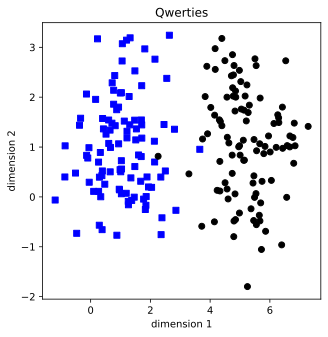

In [92]:
# creating dataset

# parameters
n_per_cluster = 100
blur = 1

# center of data cloud
A = [1,1]
B = [5,1]

# generating data points
a = [A[0]+np.random.randn(n_per_cluster)*blur, A[1]+np.random.randn(n_per_cluster)*blur]
b = [B[0]+np.random.randn(n_per_cluster)*blur, B[1]+np.random.randn(n_per_cluster)*blur]

# category labels (dummy or 'hot' encoding)
labels_np = np.vstack((np.zeros((n_per_cluster,1)), np.ones((n_per_cluster, 1)))) # all of dataset a is labeled as 0, all of b as 1

# concatenate data into matrix
data_np = np.hstack((a,b)).T

# convert numpy matrix to pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# plotting data

fig = plt.figure(figsize=(5,5))

plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bs')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ko')

plt.title('Qwerties')
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')

plt.show()

In [97]:
# building and training model

def ANN_classify_build_train(input_data, input_labels, learning_rate=0.01, epochs = 1000):
    # building ANN model
    ANN_classify = nn.Sequential(
    nn.Linear(2,1), # input. Data is two dimensional. 2 inputs, 1 output.
    nn.ReLU(), # activation
    nn.Linear(1,1), # output
    nn.Sigmoid() # activation. Generally not recommended to include this layer here. Depends on loss function you are using.
    )

    # parameters
    loss_func = nn.BCELoss() # binary cross entropy loss function. Recommended to use BCEWithLogitsLoss() instead.
    optimizer = torch.optim.SGD(ANN_classify.parameters(), lr=learning_rate)
    losses = torch.zeros(epochs)

    # training
    for epoch_IDX in range(epochs):
        # forward pass
        y_hat = ANN_classify(input_data)

        # calculating loss
        loss = loss_func(y_hat, input_labels)
        losses[epoch_IDX] = loss

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # final forward pass
    final_predictions = ANN_classify(data)
    return final_predictions,losses

In [98]:
# building / training model on data
results,model_losses = ANN_classify_build_train(data, labels) # results will be between [0,1]

In [99]:
# manually calculating losses
predicted_labels = results > 0.5 # True (1) if in category b. False (0) if in category b.

# finding errors
misclassified = np.where(predicted_labels != labels)[0] # checking for dataset a, which should be categorized as 0. 

# total accuracy of model
total_accuracy = 100-(100*len(misclassified))/(2*n_per_cluster)
print("Final accuracy of model: %g%%"%total_accuracy)

Final accuracy of model: 96%


### Important notes.
- values that are closer to the barrier / decision boundary (0.5) are guesses from the model that are less certain. In an ideal situation, most of the values of the output will be either close to 0 or close to 1.

- the line `predicted_labels = results > 0.5` is taking the output and 'converting' it to boolean labels. This is to interpret the results and calculate the accuracy of how the model categorized data points to either belong to a (false) or b (true). Like normal convention, false represents 0, true represents 1.

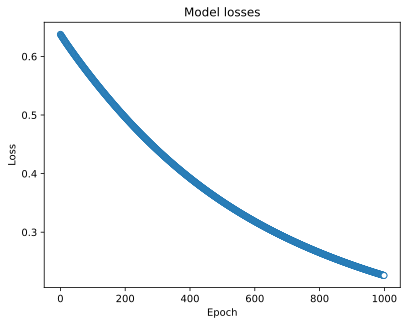

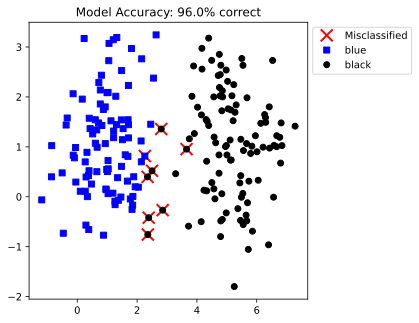

In [103]:
# plotting losses
plt.plot(model_losses.detach(), 'o', markerfacecolor='w', linewidth=0.1)
plt.title('Model losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plotting accuracy
fig = plt.figure(figsize=(5,5))
plt.plot(data[misclassified,0], data[misclassified,1], 'rx', markersize=12, markeredgewidth=2)
plt.plot(data[np.where(~predicted_labels)[0],0], data[np.where(~predicted_labels)[0],1], 'bs')
plt.plot(data[np.where(predicted_labels)[0],0], data[np.where(predicted_labels)[0], 1], 'ko')

plt.legend(['Misclassified', 'blue', 'black'], bbox_to_anchor=(1,1))
plt.title(f'Model Accuracy: {total_accuracy}% correct')
plt.show()

### Interpreting the results

**In a loss graph:**
- if the losses have *not* hit an **asymptote** at the bottom of the graph, there is **more learning** that the model can do.
- To fix this there are three main things you can do:
    1. Change learning rate.
    2. Change epochs.
    3. Change optimizer.<br>

**In the accuracy graph:**
- the model basically just drew a line. In the graph, the points marked with an x should be the other marker than what is showed. 
- It just tried to have everything above the line be set a, and everything below the line be set b.